In [148]:
import numpy
import numpy as np
import pandas as pd
import re
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

from utils.util import plot_results, plot_comparison

### Extract data from file by the special keyword


In [149]:
# extract data from log file by the special keyword
def read_log(file, model_name):
    line_list = []
    with open(file) as f:
        while True:
            lines = f.readline()
            line_list.append(lines)
            if not lines:
                break
    # print(line_list)
    if model_name == 'Mlp':
        keyline = "INFO - Average testing results among all repeated 80-20 holdouts:\n"
    elif model_name == 'SVR':
        keyline = "INFO: Average testing results among all repeated 80-20 holdouts:\n"
    for i in range(len(line_list)):
        if line_list[i] == keyline:
            key_index = i
    srcc = line_list[key_index + 1]
    krcc = line_list[key_index + 2]
    plcc = line_list[key_index + 3]
    rmse = line_list[key_index + 4]
    return srcc, krcc, plcc, rmse

def get_value(coef, model_name):
    if model_name == 'Mlp':
        pattern = r"INFO - (\w+): (\d+\.\d+) \(std: (\d+\.\d+)\)"
    elif model_name == 'SVR':
        pattern = r"INFO: (\w+): (\d+\.\d+) \(std: (\d+\.\d+)\)"

    matches = re.findall(pattern, coef)
    for match in matches:
        metric, value, std_dev = match
        value = format(float(value), '.4f')
        std_dev = format(float(std_dev), '.4f')
        plusmius = u"\u00B1"
        coef_value = f"{value} ({plusmius}{std_dev})"
    return coef_value

def process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria):
    data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = [], [], [], [], [], [], []

    for data in data_name:
        for network in network_name:
            for layer in layer_name:
                if data == 'lsvq_train_on_test':
                    log_file = f'{log_path}/lsvq_train_{network}_{layer}_{model_name}_corr_{select_criteria}_onLSVQ_TEST.log'
                elif data == 'lsvq_train_on_test_1080P':
                    log_file = f'{log_path}/lsvq_train_{network}_{layer}_{model_name}_corr_{select_criteria}_onLSVQ_TEST_1080P.log'
                elif 'residual' in data or 'merged' in data:

                    if '_of' in data:
                        if '_frag' in data:
                            log_file = f"{log_path}/{data.replace('_residual_of_frag', '')}_{network}_{layer}_{model_name}_corr_{select_criteria}_residual_of_frag.log"
                        else:
                            log_file = f"{log_path}/{data.replace('_residual_of', '')}_{network}_{layer}_{model_name}_corr_{select_criteria}_residual_of.log"
                    elif '_merged' in data:
                        log_file = f"{log_path}/{data.replace('_merged_frag', '')}_{network}_{layer}_{model_name}_corr_{select_criteria}_residual_merged_frag.log"
                    else:
                        if '_frag' in data:
                            log_file = f"{log_path}/{data.replace('_residual_frag', '')}_{network}_{layer}_{model_name}_corr_{select_criteria}_residual_frag.log"
                        else:
                            log_file = f"{log_path}/{data.replace('_residual', '')}_{network}_{layer}_{model_name}_corr_{select_criteria}_residual.log"
                else:
                    log_file = f'{log_path}/{data}_{network}_{layer}_{model_name}_corr_{select_criteria}.log'
                    
                if not os.path.exists(log_file):
                    continue  # skip if the file doesn't exist
                with open(log_file, "r", encoding="UTF-8") as file:
                    srcc, krcc, plcc, rmse = read_log(log_file, model_name)
                    srcc = get_value(srcc, model_name)
                    krcc = get_value(krcc, model_name)
                    plcc = get_value(plcc, model_name)
                    rmse = get_value(rmse, model_name)

                data_list.append(data)
                network_list.append(network)
                if data in ('konvid_1k_residual_frag', 'konvid_1k_residual_of', 'konvid_1k_residual_of_frag', 'konvid_1k_merged_frag'):
                    if network == 'vit':
                        layer_r = 'pool'
                    else:
                        layer_r = 'layer_stack+pool'
                else:
                    if network == 'vit':
                        layer_r = 'pool'
                    elif network == 'resnet50' or network == 'vgg16':
                        layer_r = 'layer_stack'
                    else:
                        layer_r = 'layer_stack+pool'
                layer_list.append(layer_r)
                srcc_list.append(srcc)
                krcc_list.append(krcc)
                plcc_list.append(plcc)
                rmse_list.append(rmse)
    return data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list

def create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list):
    df_results = pd.DataFrame(columns=['DATASET', 'MODEL', 'LAYER_NAME', 'SRCC (±STD)', 'KRCC (±STD)', 'PLCC (±STD)', 'RMSE (±STD)'])

    df_results['DATASET'] = data_list
    df_results['MODEL'] = network_list
    df_results['LAYER_NAME'] = layer_list
    df_results['SRCC (±STD)'] = srcc_list
    df_results['KRCC (±STD)'] = krcc_list
    df_results['PLCC (±STD)'] = plcc_list
    df_results['RMSE (±STD)'] = rmse_list
    return df_results

In [150]:
# read log file
log_base_path = "../log/"

In [151]:
data_name = ['lsvq_train_on_test_1080P', 'lsvq_train_on_test']
layer_name = ['layer_stack']
network_name = ['vgg16', 'vgg16_vit', 'resnet50', 'vit', 'resnet50_vit']
model_name = 'Mlp'
select_criteria = 'bykrcc'
log_path = f'{log_base_path}/lsvq/'
data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria)
df_results = create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list)
print(f'Model_name: {model_name}, Select_criteria: {select_criteria}')
df_results

Model_name: Mlp, Select_criteria: bykrcc


,DATASET,MODEL,LAYER_NAME,SRCC (±STD),KRCC (±STD),PLCC (±STD),RMSE (±STD)
0,lsvq_train_on_test_1080P,vgg16,layer_stack,0.6340 (±0.0162),0.4554 (±0.0131),0.7049 (±0.0119),7.3619 (±0.1185)
1,lsvq_train_on_test_1080P,vgg16_vit,layer_stack+pool,0.6756 (±0.0114),0.4918 (±0.0101),0.7319 (±0.0105),7.0722 (±0.1131)
2,lsvq_train_on_test_1080P,resnet50,layer_stack,0.6876 (±0.0122),0.5018 (±0.0104),0.7411 (±0.0105),6.9677 (±0.1147)
3,lsvq_train_on_test_1080P,vit,pool,0.6376 (±0.0085),0.4583 (±0.0068),0.6976 (±0.0090),7.4361 (±0.0869)
4,lsvq_train_on_test_1080P,resnet50_vit,layer_stack+pool,0.7005 (±0.0068),0.5136 (±0.0062),0.7518 (±0.0059),6.8439 (±0.0687)
5,lsvq_train_on_test,vgg16,layer_stack,0.8195 (±0.0075),0.6263 (±0.0079),0.8203 (±0.0065),5.9940 (±0.0946)
6,lsvq_train_on_test,vgg16_vit,layer_stack+pool,0.8251 (±0.0084),0.6329 (±0.0090),0.8271 (±0.0086),5.8912 (±0.1259)
7,lsvq_train_on_test,resnet50,layer_stack,0.8294 (±0.0044),0.6378 (±0.0048),0.8311 (±0.0042),5.8289 (±0.0648)
8,lsvq_train_on_test,vit,pool,0.7658 (±0.0094),0.5717 (±0.0093),0.7734 (±0.0094),6.6431 (±0.1160)
9,lsvq_train_on_test,resnet50_vit,layer_stack+pool,0.8345 (±0.0069),0.6433 (±0.0078),0.8370 (±0.0070),5.7346 (±0.1081)


In [152]:
data_name = ['lsvq_train_on_test_1080P', 'lsvq_train_on_test']
layer_name = ['layer_stack']
network_name = ['vgg16', 'vgg16_vit', 'resnet50', 'vit', 'resnet50_vit']
model_name = 'Mlp'
select_criteria = 'byrmse'
log_path = f'{log_base_path}/lsvq/'
data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria)
df_results = create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list)
print(f'Model_name: {model_name}, Select_criteria: {select_criteria}')
df_results

Model_name: Mlp, Select_criteria: byrmse


,DATASET,MODEL,LAYER_NAME,SRCC (±STD),KRCC (±STD),PLCC (±STD),RMSE (±STD)
0,lsvq_train_on_test_1080P,vgg16,layer_stack,0.6284 (±0.0070),0.4513 (±0.0059),0.7007 (±0.0059),7.4047 (±0.0602)
1,lsvq_train_on_test_1080P,vgg16_vit,layer_stack+pool,0.6699 (±0.0134),0.4862 (±0.0118),0.7279 (±0.0103),7.1161 (±0.1110)
2,lsvq_train_on_test_1080P,resnet50,layer_stack,0.6860 (±0.0092),0.5000 (±0.0083),0.7408 (±0.0069),6.9713 (±0.0760)
3,lsvq_train_on_test_1080P,vit,pool,0.6351 (±0.0072),0.4571 (±0.0061),0.6966 (±0.0065),7.4463 (±0.0652)
4,lsvq_train_on_test_1080P,resnet50_vit,layer_stack+pool,0.7006 (±0.0121),0.5131 (±0.0105),0.7511 (±0.0105),6.8525 (±0.1162)
5,lsvq_train_on_test,vgg16,layer_stack,0.8199 (±0.0062),0.6270 (±0.0066),0.8207 (±0.0059),5.9876 (±0.0851)
6,lsvq_train_on_test,vgg16_vit,layer_stack+pool,0.8258 (±0.0066),0.6341 (±0.0073),0.8282 (±0.0073),5.8738 (±0.1086)
7,lsvq_train_on_test,resnet50,layer_stack,0.8301 (±0.0016),0.6383 (±0.0018),0.8320 (±0.0016),5.8149 (±0.0256)
8,lsvq_train_on_test,vit,pool,0.7651 (±0.0057),0.5705 (±0.0056),0.7735 (±0.0051),6.6428 (±0.0645)
9,lsvq_train_on_test,resnet50_vit,layer_stack+pool,0.8363 (±0.0035),0.6453 (±0.0039),0.8383 (±0.0035),5.7143 (±0.0558)


In [153]:
# data_name = ['konvid_1k', 'konvid_1k_residual', 'konvid_1k_residual_frag', 'konvid_1k_residual_of', 'konvid_1k_residual_of_frag', 'konvid_1k_merged_frag']
data_name = ['konvid_1k', 'konvid_1k_merged_frag']
layer_name = ['layer_stack', 'pool']
# network_name = ['vgg16', 'vgg16_vit', 'resnet50', 'vit', 'resnet50_vit', 
#                 'resnet50_r_resnet50', 'vit_r_resnet50', 'resnet50_vit_r_resnet50', 'resnet50_r_vit', 'vit_r_vit', 'resnet50_vit_r_vit', 
#                 'resnet50_rfrag_vit', 'vit_rfrag_vit', 'resnet50_vit_rfrag_vit',
#                 'resnet50_rof_vit', 'vit_rof_vit', 'resnet50_vit_rof_vit',
#                 'resnet50_roffrag_vit', 'vit_roffrag_vit', 'resnet50_vit_roffrag_vit',
#                 'resnet50_ori_rfrag_merged_resnet50', 'resnet50_ori_rfrag_merged_vit', 'vit_ori_rfrag_merged_resnet50', 'vit_ori_rfrag_merged_vit',
#                 'resnet50_vit_ori_rfrag_merged_resnet50', 'resnet50_vit_ori_rfrag_merged_vit', 
#                 'ori_rfrag_merged_resnet50_ori_rfrag_merged_vit', 'resnet50_vit_ori_rfrag_merged_resnet50_ori_rfrag_merged_vit'] 
network_name = ['vgg16', 'vgg16_vit', 'resnet50', 'vit', 'resnet50_vit',
                'resnet50_ori_rfrag_merged_resnet50', 'resnet50_ori_rfrag_merged_vit', 'vit_ori_rfrag_merged_resnet50', 'vit_ori_rfrag_merged_vit',
                'resnet50_vit_ori_rfrag_merged_resnet50', 'resnet50_vit_ori_rfrag_merged_vit', 
                'ori_rfrag_merged_resnet50_ori_rfrag_merged_vit', 'resnet50_vit_ori_rfrag_merged_resnet50_ori_rfrag_merged_vit'] 
model_name = 'Mlp'
select_criteria = 'byrmse'
log_path = f'{log_base_path}/konvid_1k'
data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria)
df_results = create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list)
print(f'Model_name: {model_name}, Select_criteria: {select_criteria}')
df_results

Model_name: Mlp, Select_criteria: byrmse


,DATASET,MODEL,LAYER_NAME,SRCC (±STD),KRCC (±STD),PLCC (±STD),RMSE (±STD)
0,konvid_1k,vgg16,layer_stack,0.7513 (±0.0250),0.5626 (±0.0228),0.7700 (±0.0219),0.4108 (±0.0186)
1,konvid_1k,vgg16,layer_stack,0.6665 (±0.0370),0.4878 (±0.0313),0.6880 (±0.0328),0.4629 (±0.0188)
2,konvid_1k,vgg16_vit,layer_stack+pool,0.7650 (±0.0245),0.5742 (±0.0236),0.7827 (±0.0213),0.4042 (±0.0177)
3,konvid_1k,vgg16_vit,layer_stack+pool,0.7100 (±0.0273),0.5210 (±0.0235),0.7364 (±0.0247),0.4370 (±0.0153)
4,konvid_1k,resnet50,layer_stack,0.7630 (±0.0239),0.5699 (±0.0219),0.7828 (±0.0224),0.3990 (±0.0162)
5,konvid_1k,resnet50,layer_stack,0.6751 (±0.0313),0.4881 (±0.0257),0.7047 (±0.0292),0.4550 (±0.0162)
6,konvid_1k,vit,pool,0.6661 (±0.0396),0.4906 (±0.0332),0.7082 (±0.0356),0.4515 (±0.0199)
7,konvid_1k,resnet50_vit,layer_stack+pool,0.7697 (±0.0230),0.5779 (±0.0213),0.7897 (±0.0209),0.3948 (±0.0152)
8,konvid_1k,resnet50_vit,layer_stack+pool,0.7253 (±0.0259),0.5308 (±0.0223),0.7469 (±0.0263),0.4277 (±0.0151)
9,konvid_1k_merged_frag,resnet50,layer_stack+pool,0.8018 (±0.0242),0.6089 (±0.0232),0.8006 (±0.0223),0.3830 (±0.0155)


In [154]:
data_name = ['youtube_ugc', 'youtube_ugc_merged_frag']
layer_name = ['layer_stack', 'pool']
network_name = ['resnet50', 'vit', 'resnet50_vit', 
                'resnet50_ori_rfrag_merged_resnet50', 'resnet50_ori_rfrag_merged_vit', 'vit_ori_rfrag_merged_resnet50', 'vit_ori_rfrag_merged_vit',
                'resnet50_vit_ori_rfrag_merged_resnet50', 'resnet50_vit_ori_rfrag_merged_vit', 
                'ori_rfrag_merged_resnet50_ori_rfrag_merged_vit', 'resnet50_vit_ori_rfrag_merged_resnet50_ori_rfrag_merged_vit'] 
model_name = 'Mlp'
select_criteria = 'byrmse'
log_path = f'{log_base_path}/youtube_ugc/'
data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria)
df_results = create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list)
print(f'Model_name: {model_name}, Select_criteria: {select_criteria}')
df_results

Model_name: Mlp, Select_criteria: byrmse


,DATASET,MODEL,LAYER_NAME,SRCC (±STD),KRCC (±STD),PLCC (±STD),RMSE (±STD)
0,youtube_ugc,resnet50,layer_stack,0.7218 (±0.0327),0.5284 (±0.0303),0.7426 (±0.0317),0.4367 (±0.0238)
1,youtube_ugc,vit,pool,0.6176 (±0.0442),0.4428 (±0.0351),0.6316 (±0.0445),0.5054 (±0.0187)
2,youtube_ugc,resnet50_vit,layer_stack+pool,0.7336 (±0.0309),0.5387 (±0.0293),0.7529 (±0.0312),0.4294 (±0.0238)
3,youtube_ugc_merged_frag,resnet50_ori_rfrag_merged_resnet50,layer_stack+pool,0.7840 (±0.0189),0.5989 (±0.0190),0.8013 (±0.0191),0.3920 (±0.0183)
4,youtube_ugc_merged_frag,resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.7882 (±0.0235),0.5966 (±0.0243),0.8068 (±0.0249),0.3941 (±0.0227)
5,youtube_ugc_merged_frag,vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.7446 (±0.0232),0.5534 (±0.0203),0.7598 (±0.0217),0.4276 (±0.0153)
6,youtube_ugc_merged_frag,vit_ori_rfrag_merged_vit,layer_stack+pool,0.7278 (±0.0380),0.5407 (±0.0326),0.7413 (±0.0330),0.4407 (±0.0227)
7,youtube_ugc_merged_frag,resnet50_vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.7906 (±0.0196),0.6040 (±0.0199),0.8088 (±0.0188),0.3889 (±0.0176)
8,youtube_ugc_merged_frag,resnet50_vit_ori_rfrag_merged_vit,layer_stack+pool,0.7927 (±0.0247),0.5984 (±0.0254),0.8080 (±0.0247),0.3889 (±0.0223)
9,youtube_ugc_merged_frag,ori_rfrag_merged_resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.7314 (±0.0260),0.5410 (±0.0235),0.7381 (±0.0250),0.4408 (±0.0189)


In [155]:
data_name = ['live_vqc', 'live_vqc_merged_frag']
log_path = f'{log_base_path}/live_vqc/'
data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria)
df_results = create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list)
print(f'Model_name: {model_name}, Select_criteria: {select_criteria}')
df_results

Model_name: Mlp, Select_criteria: byrmse


,DATASET,MODEL,LAYER_NAME,SRCC (±STD),KRCC (±STD),PLCC (±STD),RMSE (±STD)
0,live_vqc,resnet50,layer_stack,0.6670 (±0.0575),0.4804 (±0.0490),0.7332 (±0.0470),11.2548 (±0.9527)
1,live_vqc,vit,pool,0.6219 (±0.0584),0.4456 (±0.0482),0.7095 (±0.0531),11.9760 (±0.9364)
2,live_vqc,resnet50_vit,layer_stack+pool,0.6705 (±0.0546),0.4895 (±0.0475),0.7392 (±0.0710),11.2869 (±1.2200)
3,live_vqc_merged_frag,resnet50_ori_rfrag_merged_resnet50,layer_stack+pool,0.7535 (±0.0439),0.5678 (±0.0415),0.7838 (±0.0562),10.3784 (±1.0173)
4,live_vqc_merged_frag,resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.7407 (±0.2829),0.5602 (±0.2100),0.7775 (±0.0740),10.7108 (±1.4899)
5,live_vqc_merged_frag,vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.7584 (±0.0390),0.5673 (±0.0379),0.7824 (±0.0532),10.3602 (±0.9900)
6,live_vqc_merged_frag,vit_ori_rfrag_merged_vit,layer_stack+pool,0.7665 (±0.0392),0.5782 (±0.0376),0.7974 (±0.0403),10.1267 (±0.9577)
7,live_vqc_merged_frag,resnet50_vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.7555 (±0.0445),0.5706 (±0.0422),0.7907 (±0.0706),10.3514 (±1.2522)
8,live_vqc_merged_frag,resnet50_vit_ori_rfrag_merged_vit,layer_stack+pool,0.7607 (±0.0442),0.5774 (±0.0433),0.7994 (±0.0510),10.2624 (±1.0419)
9,live_vqc_merged_frag,ori_rfrag_merged_resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.7490 (±0.0411),0.5519 (±0.0393),0.7874 (±0.0389),10.3694 (±0.8490)


In [156]:
data_name = ['cvd_2014', 'cvd_2014_merged_frag']
log_path = f'{log_base_path}/cvd_2014/'
data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria)
df_results = create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list)
print(f'Model_name: {model_name}, Select_criteria: {select_criteria}')
df_results

Model_name: Mlp, Select_criteria: byrmse


,DATASET,MODEL,LAYER_NAME,SRCC (±STD),KRCC (±STD),PLCC (±STD),RMSE (±STD)
0,cvd_2014,resnet50,layer_stack,0.8548 (±0.0347),0.6799 (±0.0476),0.8714 (±0.0341),10.3366 (±1.2866)
1,cvd_2014,vit,pool,0.7841 (±0.0537),0.5948 (±0.0597),0.7775 (±0.0612),12.8483 (±1.6200)
2,cvd_2014,resnet50_vit,layer_stack+pool,0.8605 (±0.0326),0.6892 (±0.0467),0.8793 (±0.0260),10.0007 (±0.9794)
3,cvd_2014_merged_frag,resnet50_ori_rfrag_merged_resnet50,layer_stack+pool,0.8664 (±0.0325),0.6873 (±0.0486),0.8863 (±0.0326),9.7738 (±1.2883)
4,cvd_2014_merged_frag,resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.8590 (±0.0339),0.6818 (±0.0482),0.8762 (±0.0337),10.2301 (±1.3565)
5,cvd_2014_merged_frag,vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.8522 (±0.0325),0.6744 (±0.0436),0.8722 (±0.0281),10.3611 (±1.0675)
6,cvd_2014_merged_frag,vit_ori_rfrag_merged_vit,layer_stack+pool,0.8098 (±0.0508),0.6244 (±0.0575),0.8328 (±0.0500),11.7821 (±1.5742)
7,cvd_2014_merged_frag,resnet50_vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.8670 (±0.0304),0.6929 (±0.0460),0.8895 (±0.0298),9.6176 (±1.1948)
8,cvd_2014_merged_frag,resnet50_vit_ori_rfrag_merged_vit,layer_stack+pool,0.8607 (±0.0357),0.6799 (±0.0509),0.8793 (±0.0418),10.1220 (±1.4201)
9,cvd_2014_merged_frag,ori_rfrag_merged_resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.8303 (±0.0367),0.6503 (±0.0510),0.8683 (±0.0322),10.6360 (±1.2924)


In [157]:
data_name = ['live_qualcomm', 'live_qualcomm_merged_frag']
log_path = f'{log_base_path}/live_qualcomm/'
data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria)
df_results = create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list)
print(f'Model_name: {model_name}, Select_criteria: {select_criteria}')
df_results

Model_name: Mlp, Select_criteria: byrmse


,DATASET,MODEL,LAYER_NAME,SRCC (±STD),KRCC (±STD),PLCC (±STD),RMSE (±STD)
0,live_qualcomm,resnet50,layer_stack,0.5931 (±0.0852),0.4286 (±0.0714),0.6342 (±0.0776),8.7888 (±1.1621)
1,live_qualcomm,vit,pool,0.4725 (±0.1063),0.3333 (±0.0812),0.5005 (±0.0908),10.0333 (±0.9141)
2,live_qualcomm,resnet50_vit,layer_stack+pool,0.5879 (±0.0781),0.4239 (±0.0672),0.6069 (±0.0890),8.9285 (±0.9824)
3,live_qualcomm_merged_frag,resnet50_ori_rfrag_merged_resnet50,layer_stack+pool,0.7193 (±0.0710),0.5470 (±0.0679),0.7535 (±0.0602),7.8314 (±0.8752)
4,live_qualcomm_merged_frag,resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.6632 (±0.0754),0.4890 (±0.0707),0.6944 (±0.0799),8.3434 (±0.9973)
5,live_qualcomm_merged_frag,vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.7164 (±0.0767),0.5517 (±0.0690),0.7510 (±0.0754),7.7762 (±0.9756)
6,live_qualcomm_merged_frag,vit_ori_rfrag_merged_vit,layer_stack+pool,0.6707 (±0.0761),0.4936 (±0.0654),0.7219 (±0.0770),8.1809 (±1.0867)
7,live_qualcomm_merged_frag,resnet50_vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.7125 (±0.0774),0.5401 (±0.0711),0.7518 (±0.0731),7.9506 (±0.9913)
8,live_qualcomm_merged_frag,resnet50_vit_ori_rfrag_merged_vit,layer_stack+pool,0.6551 (±0.0731),0.4843 (±0.0636),0.6750 (±0.0768),8.5091 (±1.1205)
9,live_qualcomm_merged_frag,ori_rfrag_merged_resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.7076 (±0.0669),0.5354 (±0.0589),0.7440 (±0.0574),7.7823 (±0.8686)


In [158]:
data_name = ['all_combined', 'all_combined_merged_frag']
log_path = f'{log_base_path}/all_combined/'
data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list = process_logs(data_name, layer_name, network_name, model_name, log_path, select_criteria)
df_results = create_results_dataframe(data_list, network_list, layer_list, srcc_list, krcc_list, plcc_list, rmse_list)
print(f'Model_name: {model_name}, Select_criteria: {select_criteria}')
df_results

Model_name: Mlp, Select_criteria: byrmse


,DATASET,MODEL,LAYER_NAME,SRCC (±STD),KRCC (±STD),PLCC (±STD),RMSE (±STD)
0,all_combined,resnet50,layer_stack,0.7784 (±0.0100),0.5821 (±0.0098),0.7910 (±0.0133),11.0689 (±0.3075)
1,all_combined,vit,pool,0.7227 (±0.0191),0.5326 (±0.0172),0.7455 (±0.0183),12.1000 (±0.3941)
2,all_combined,resnet50_vit,layer_stack+pool,0.7922 (±0.0120),0.5940 (±0.0120),0.8005 (±0.0132),10.8840 (±0.2855)
3,all_combined_merged_frag,resnet50_ori_rfrag_merged_resnet50,layer_stack+pool,0.8159 (±0.0111),0.6222 (±0.0117),0.8229 (±0.0118),10.1887 (±0.3410)
4,all_combined_merged_frag,resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.8145 (±0.0137),0.6210 (±0.0137),0.8212 (±0.0143),10.3075 (±0.3416)
5,all_combined_merged_frag,vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.7962 (±0.0143),0.6029 (±0.0150),0.8095 (±0.0147),10.6035 (±0.3503)
6,all_combined_merged_frag,vit_ori_rfrag_merged_vit,layer_stack+pool,0.7996 (±0.0154),0.6053 (±0.0147),0.8094 (±0.0150),10.7129 (±0.3119)
7,all_combined_merged_frag,resnet50_vit_ori_rfrag_merged_resnet50,layer_stack+pool,0.8177 (±0.0196),0.6226 (±0.0205),0.8225 (±0.0201),10.2192 (±0.4750)
8,all_combined_merged_frag,resnet50_vit_ori_rfrag_merged_vit,layer_stack+pool,0.8102 (±0.0125),0.6182 (±0.0133),0.8198 (±0.0122),10.2864 (±0.3673)
9,all_combined_merged_frag,ori_rfrag_merged_resnet50_ori_rfrag_merged_vit,layer_stack+pool,0.7836 (±0.0146),0.5938 (±0.0147),0.7978 (±0.0138),11.0046 (±0.2913)


In [159]:
# csv_name = f'../save_csv/{data_name}_{model_name}log.csv'
# df_results.to_csv(csv_name, index=None, encoding="UTF-8")
# xlsx_name = f'../save_csv/{data_name}_{model_name}log.xlsx'
# df_results.to_excel(xlsx_name, index=False, encoding="utf-8")

## Plot visualisation

In [160]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080 at 0x139750F40>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080 at 0x139750340>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x139750AF0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x139EDABB0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080 at 0x13972FCD0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080 at 0x13972FB80>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x13972F8B0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x13972F580>


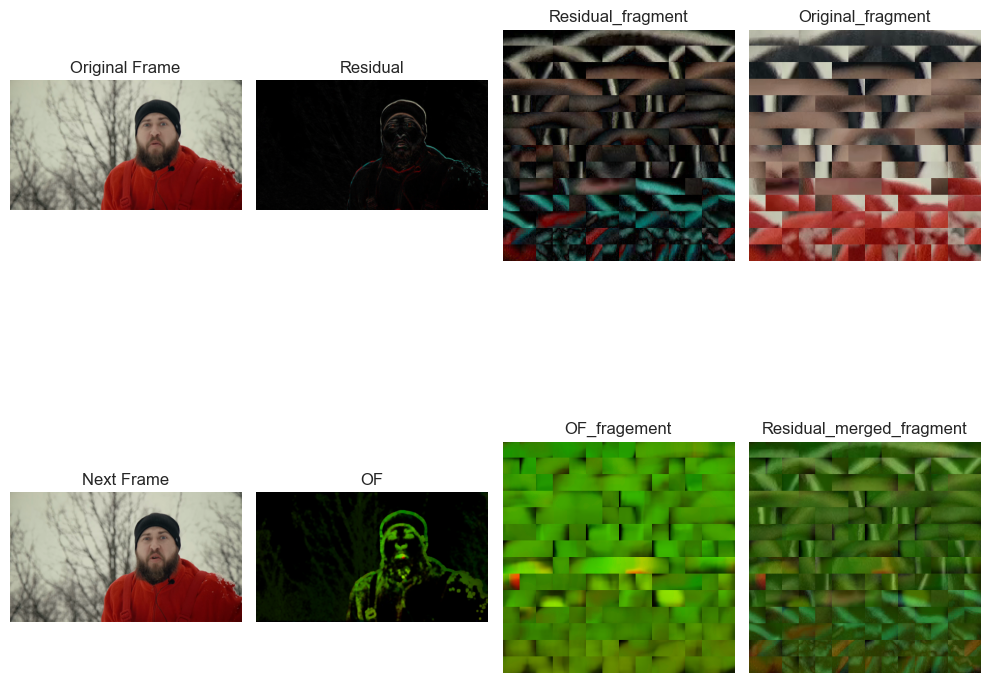

In [161]:
video_name = 'TelevisionClip_1080P-68c6' # 'TelevisionClip_1080P-68c6', 'Sports_2160P-0455', '5636101558'
frame_number = 3

img_paths = [
    f'../visualisation/visualisation_example/original_{video_name}/{video_name}_{frame_number}.png',
    f'../visualisation/visualisation_example/original_{video_name}/{video_name}_{frame_number}_residual.png',
    f'../visualisation/visualisation_example/original_{video_name}/{video_name}_{frame_number}_residual_imp.png',
    f'../visualisation/visualisation_example/original_{video_name}/{video_name}_{frame_number}_ori_frag.png', 
    f'../visualisation/visualisation_example/original_{video_name}/{video_name}_{frame_number}_next.png',
    f'../visualisation/visualisation_example/original_{video_name}/{video_name}_{frame_number}_residual_of.png',
    f'../visualisation/visualisation_example/original_{video_name}/{video_name}_{frame_number}_residual_of_imp.png',
    f'../visualisation/visualisation_example/original_{video_name}/{video_name}_{frame_number}_residual_merged_frag.png'
]
titles = [
    'Original Frame',
    'Residual',
    'Residual_fragment',
    'Original_fragment',
    'Next Frame',
    'OF',
    'OF_fragement',
    'Residual_merged_fragment'
]
fig, axs = plt.subplots(2, 4, figsize=(10, 10))
axs = axs.ravel()

for ax, img_path, title in zip(axs, img_paths, titles):
    img = Image.open(img_path)
    print(img)
    ax.imshow(img)
    ax.set_title(title) 
    ax.axis('off')

plt.tight_layout()
plt.show()

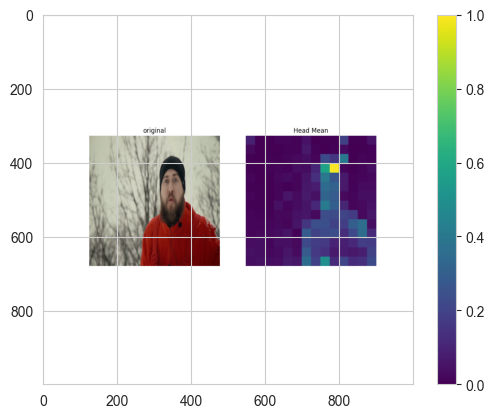

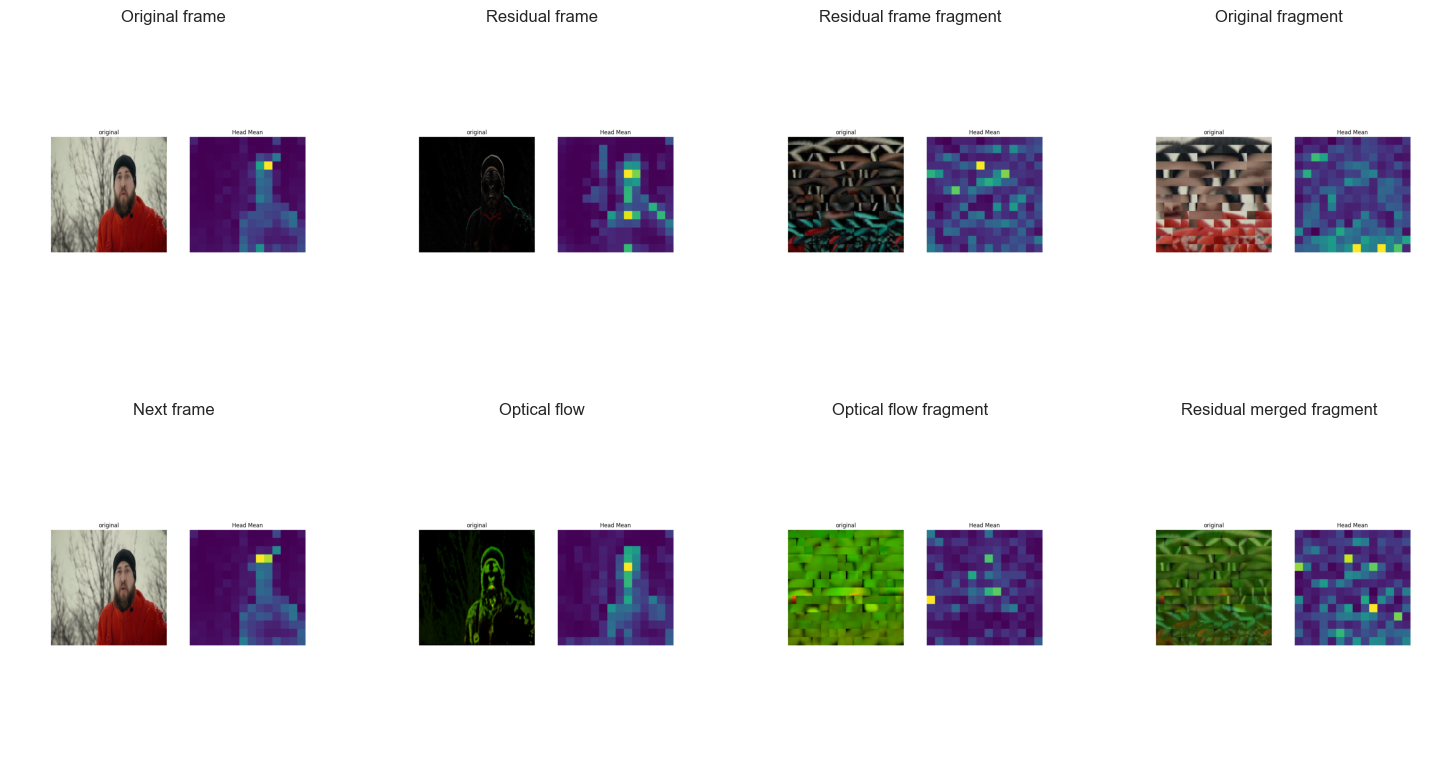

In [162]:
img1 = mpimg.imread(f'../visualisation/visualisation_example/vit_{video_name}/frame_{frame_number}/vit_feature_map_original_head_mean.png')
img2 = mpimg.imread(f'../visualisation/visualisation_example/vit_{video_name}/frame_{frame_number}_residual/vit_feature_map_original_head_mean.png')
img3 = mpimg.imread(f'../visualisation/visualisation_example/vit_{video_name}/frame_{frame_number}_residual_imp/vit_feature_map_original_head_mean.png')
img4 = mpimg.imread(f'../visualisation/visualisation_example/vit_{video_name}/frame_{frame_number}_ori_frag/vit_feature_map_original_head_mean.png')
img5 = mpimg.imread(f'../visualisation/visualisation_example/vit_{video_name}/frame_{frame_number}_next/vit_feature_map_original_head_mean.png')
img6 = mpimg.imread(f'../visualisation/visualisation_example/vit_{video_name}/frame_{frame_number}_residual_of/vit_feature_map_original_head_mean.png')
img7 = mpimg.imread(f'../visualisation/visualisation_example/vit_{video_name}/frame_{frame_number}_residual_of_imp/vit_feature_map_original_head_mean.png')
img8 = mpimg.imread(f'../visualisation/visualisation_example/vit_{video_name}/frame_{frame_number}_residual_merged_frag/vit_feature_map_original_head_mean.png')

colormap = 'viridis' # viridis, plasma, inferno
if img1.dtype == np.float32 or img1.dtype == np.float64:
    img1 = np.clip(img1, 0.0, 1.0)
elif img1.dtype == np.uint8:
    img1 = img1.astype(float) / 255
plt.imshow(img1, cmap=colormap)
plt.colorbar() 
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(16, 8)) 
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.2)

imgs = [img1, img2, img3, img4, img5, img6, img7, img8] 
titles = ['Original frame', 'Residual frame', 'Residual frame fragment', 'Original fragment',
          'Next frame', 'Optical flow', 'Optical flow fragment', 'Residual merged fragment']

for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i], cmap=colormap)
    ax.set_title(titles[i])
    ax.axis('off')
plt.show()

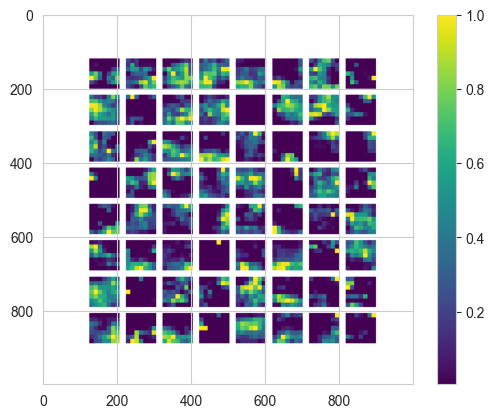

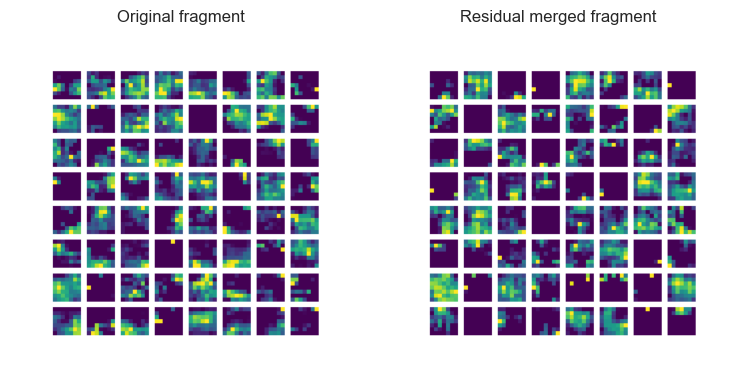

In [163]:
layer_number = 'resnet50.layer4[2]' # 'resnet50.layer1[0]'
img1 = mpimg.imread(f'../visualisation/visualisation_example/resnet_{video_name}/frame_{frame_number}_ori_frag/resnet50_feature_map_qp_original_layer_{layer_number}.png')
img2 = mpimg.imread(f'../visualisation/visualisation_example/resnet_{video_name}/frame_{frame_number}_residual_merged_frag/resnet50_feature_map_qp_original_layer_{layer_number}.png')

colormap = 'viridis' # viridis, plasma, inferno
if img1.dtype == np.float32 or img1.dtype == np.float64:
    img1 = np.clip(img1, 0.0, 1.0)
elif img1.dtype == np.uint8:
    img1 = img1.astype(float) / 255
plt.imshow(img1, cmap=colormap)
plt.colorbar() 
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8, 8)) 
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.2)

imgs = [img1, img2] 
titles = ['Original fragment', 'Residual merged fragment']

for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i], cmap=colormap)
    ax.set_title(titles[i])
    ax.axis('off')
plt.show()

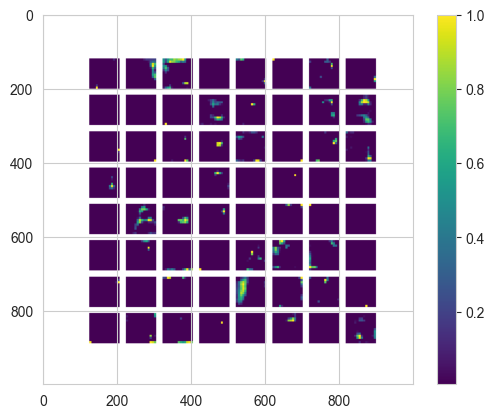

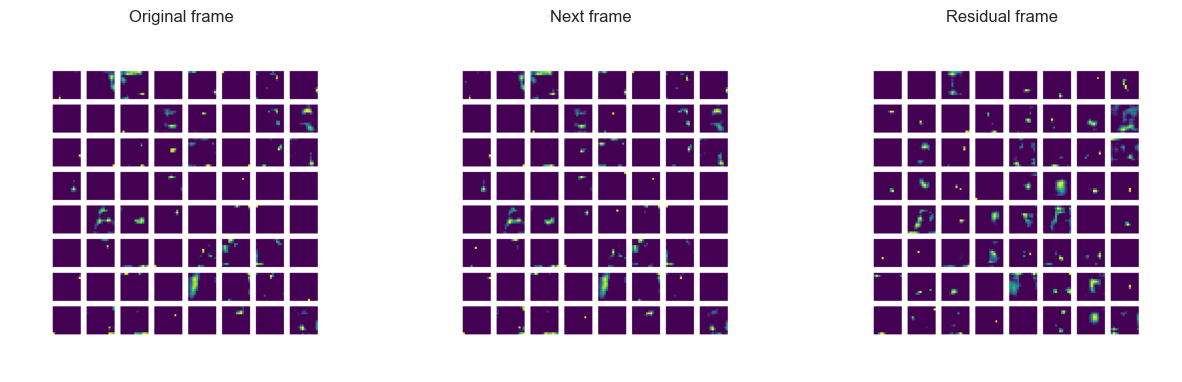

In [164]:
layer_number = 28

img1 = mpimg.imread(f'../visualisation/visualisation_example/vgg_{video_name}/frame_{frame_number}/vgg16_feature_map_qp_original_layer_{layer_number}.png')
img2 = mpimg.imread(f'../visualisation/visualisation_example/vgg_{video_name}/frame_{frame_number}_next/vgg16_feature_map_qp_original_layer_{layer_number}.png')
img3 = mpimg.imread(f'../visualisation/visualisation_example/vgg_{video_name}/frame_{frame_number}_residual/vgg16_feature_map_qp_original_layer_{layer_number}.png')

colormap = 'viridis' # viridis, plasma, inferno
if img1.dtype == np.float32 or img1.dtype == np.float64:
    img1 = np.clip(img1, 0.0, 1.0)
elif img1.dtype == np.uint8:
    img1 = img1.astype(float) / 255
plt.imshow(img1, cmap=colormap)
plt.colorbar() 
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

axs[0].imshow(img1, cmap=colormap)
axs[0].set_title('Original frame')
axs[0].axis('off') 

axs[1].imshow(img2, cmap=colormap)
axs[1].set_title('Next frame')
axs[1].axis('off')

axs[2].imshow(img3, cmap=colormap)
axs[2].set_title('Residual frame')
axs[2].axis('off')

plt.show()

## Plot the MOS Histogram

In [165]:
data_name = 'lsvq'
set_name = ['train', 'test', 'test_1080p']

In [166]:
# df = pd.read_csv(f'../metadata/mos_files/{data_name}_MOS_test.csv')
# df1 = pd.read_csv(f'../log/predict_score/{data_name}/{data_name}_{network_name}_{layer_name}_{model_name}_Predicted_Score_{select_criteria1}.csv')
# df2 = pd.read_csv(f'../log/predict_score/{data_name}/{data_name}_{network_name}_{layer_name}_{model_name}_Predicted_Score_{select_criteria2}.csv')
# if len(df) == len(df1):
#     result = pd.concat([df, df1], axis=1)  # axis=1 vertical concatenate
#     print("merge successes")
# else:
#     print("error")
# result.head()

## Plot the Predict Score

In [167]:
data_name = 'youtube_ugc'
network_name = 'vgg16'
model_name = 'Mlp'
layer_name = 'layer_stack'
select_criteria1 = 'byrmse'
select_criteria2 = 'bykrcc'

In [168]:
# # df1
# y_true = df1['MOS'].tolist()
# y_pred = df1['y_test_pred'].tolist()
# y_pred_logistic = df1['y_test_pred_logistic'].tolist()
# plot_results(y_true, y_pred_logistic, df1, network_name, model_name, data_name, layer_name, select_criteria1)
# 
# # df2
# y_true = df2['MOS'].tolist()
# y_pred = df2['y_test_pred'].tolist()
# y_pred_logistic = df2['y_test_pred_logistic'].tolist()
# plot_results(y_true, y_pred_logistic, df2, network_name, model_name, data_name, layer_name, select_criteria2)
# 
# plot_comparison(df1, df2, network_name, model_name, data_name, layer_name, select_criteria1, select_criteria2)

In [169]:
# plt.figure(figsize=(8, 6))
# combined_df = pd.DataFrame()
# for set in set_name:
#     metadata_path = f'../metadata/{data_name.upper()}_{set.upper()}_metadata.csv'
#     df = pd.read_csv(metadata_path)
#     combined_df = pd.concat([combined_df, df], axis=0)
#     print(f'Total numbers of the {set} dataset: {len(df)}')
#     column_name = 'mos'
#     plt.hist(df[column_name], bins=50, alpha=0.75, label=f'{set} {data_name}')
# 
# plt.title(f'Histogram of {column_name} across different sets')
# plt.xlabel('MOS Score')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()
# plt.close()

In [170]:
# plt.figure(figsize=(8, 6))
# combined_df = combined_df.reset_index(drop=True)
# print(f'Total numbers of the video dataset: {len(combined_df)}')
# # column_name = 'MOS'
# column_name = 'mos'
# title = f'Histogram of {column_name} on All {data_name}'
# plt.hist(combined_df[column_name], bins=50, alpha=0.75, label=f'{set} {data_name}')
# plt.title(f'Histogram of {column_name} across all set')
# plt.xlabel('MOS Score')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()
# plt.close()

In [171]:
# sns.histplot(scores, bins=50, kde=True)  # `kde=True`
# plt.title('Histogram of Subjective Score')
# plt.xlabel('Subjective Score')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()